# Evaluation of different classification algorithms for COVID-19 Pandemic Tweets

#### Stylianos Sidiropoulos (stysi607)

#### Text Mining (732A92) - Linköping University

## Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold

## Data Preprocessing

keep only useful columns, check for nulls, check if dataset is balanced, balance dataset, lowercase words, remove stopwords, punctuations, numbers, links, hashtags, mentions etc.

Dataset: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [ ]:
# Read data and merge it into one dataset
data = pd.read_csv("https://raw.githubusercontent.com/steliossid/covid19-classification/main/data.csv", encoding="latin")

not_whole_dataset = False

if not_whole_dataset:
    data = data.loc[:10000]
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# Keep only OriginalTweet and Sentiment columns
data.pop("UserName")
data.pop("ScreenName")
data.pop("Location")
data.pop("TweetAt")
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# Check if there are null values
data.isnull().values.any()

False

In [ ]:
data.shape

(44955, 2)

In [ ]:
sentiments = data.Sentiment.unique().tolist()
sentiments

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

### Balance Dataset

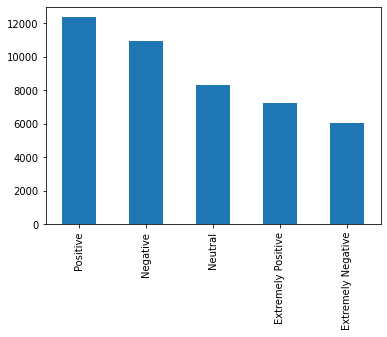

In [ ]:
data.Sentiment.value_counts().plot(kind='bar');

In [ ]:
data.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

Dataset is not balanced. (should I balance it?)

In [ ]:
# Balance dataset
count_min = data.Sentiment.value_counts().min()

# Divide by class and Random undersampling without replacement
df_Pos = data[data.Sentiment == "Positive"].sample(count_min)
df_Neg = data[data.Sentiment == "Negative"].sample(count_min)
df_Neu = data[data.Sentiment == "Neutral"].sample(count_min)
df_ExPos = data[data.Sentiment == "Extremely Positive"].sample(count_min)
df_ExNeg = data[data.Sentiment == "Extremely Negative"]

data_balanced = pd.concat([df_Pos, df_Neg, df_Neu, df_ExPos, df_ExNeg], axis=0)

In [ ]:
#data_balanced.Sentiment.value_counts().plot(kind='bar');

In [ ]:
data_balanced.Sentiment.value_counts()

Neutral               6073
Extremely Negative    6073
Extremely Positive    6073
Negative              6073
Positive              6073
Name: Sentiment, dtype: int64

In [ ]:
# Natural Language Processing (NLP)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]

In [ ]:
data_balanced["ProcessedTweet"] = data_balanced["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
data["ProcessedTweet"] = data["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
data_balanced.head()

,OriginalTweet,Sentiment,ProcessedTweet
32930,@KamVTV @VP \r\r\n@DonaldJTrumpJr ?\r\r\nGroce...,Positive,grocery store clerk touch handle away everyday...
32898,The second edition of the new Healthy At Home ...,Positive,edition new healthy home newsletter focus mana...
30185,Actions taken by amp will help to proactively ...,Positive,actions take amp help proactively mislead ad a...
3417,@UKEnterprise speaking with ur staff &amp; ask...,Positive,speak staff amp ask shutdown affect business s...
23119,"Trust no one, stay home to protect yourself an...",Positive,trust stay home protect fully kit facemask sur...


Some rows do not include anything after text processing, so we exclude them

In [ ]:
is_empty = data_balanced.ProcessedTweet==""
data_balanced = data_balanced[is_empty==False]

Minor change in the balance of the classes, no need to rebalance the classes

In [ ]:
data_balanced.Sentiment.value_counts()

Extremely Negative    6073
Extremely Positive    6073
Negative              6072
Positive              6072
Neutral               6047
Name: Sentiment, dtype: int64

In [ ]:
#data = data_balanced.copy()

## Statistics

### Number of words in tweet

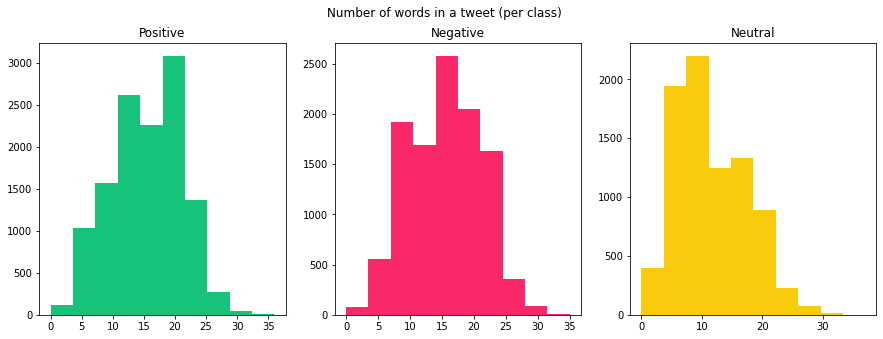

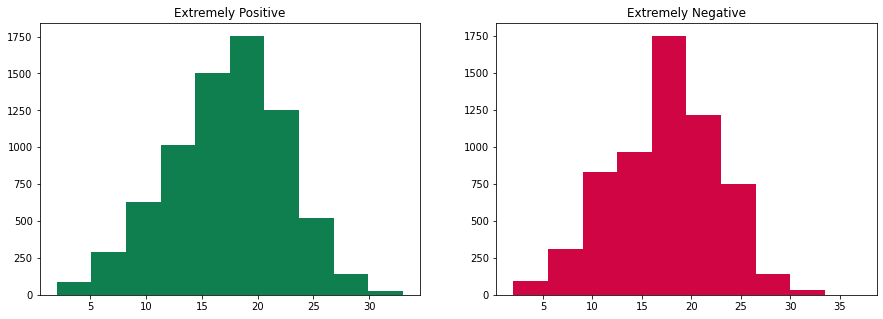

In [ ]:
fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig2,(ax4, ax5)=plt.subplots(1,2,figsize=(15,5))

len_pos = data[data['Sentiment']=="Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax1.hist(len_pos, color='#17C37B')
ax1.set_title('Positive')

len_neg = data[data['Sentiment']=="Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax2.hist(len_neg, color='#F92969')
ax2.set_title('Negative')

len_neu = data[data['Sentiment']=="Neutral"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax3.hist(len_neu, color='#FACA0C')
ax3.set_title('Neutral')

len_expos = data[data['Sentiment']=="Extremely Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax4.hist(len_expos, color='#0f7f50')
ax4.set_title('Extremely Positive')

len_exneg = data[data['Sentiment']=="Extremely Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax5.hist(len_exneg, color='#d00644')
ax5.set_title('Extremely Negative')

fig1.suptitle('Number of words in a tweet (per class)')
plt.show()

### Wordclouds

In [ ]:
def create_wordlist(sentiment):
    wordlist=[]
    words_removed = ["coronavirus", "coronaviru", "covid19", "covid-19", "covid", "amp"]
    for line in data[data["Sentiment"]==sentiment]["ProcessedTweet"].str.split():
        for word in line:
            if word not in words_removed:
                wordlist.append(word)
    return wordlist

def create_wordcloud(sentiment):
    wordcloud = WordCloud().generate(" ".join(words for words in create_wordlist(sentiment)))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(sentiment + " " + "wordcloud")
    plt.show()

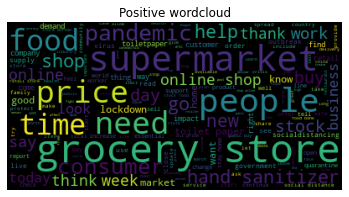

In [ ]:
create_wordcloud("Positive")

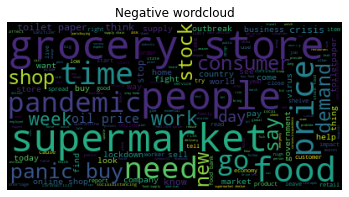

In [ ]:
create_wordcloud("Negative")

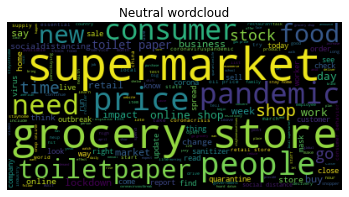

In [ ]:
create_wordcloud("Neutral")

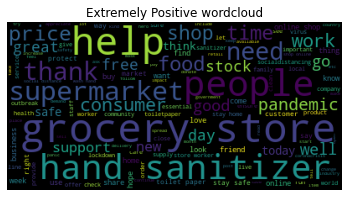

In [ ]:
create_wordcloud("Extremely Positive")

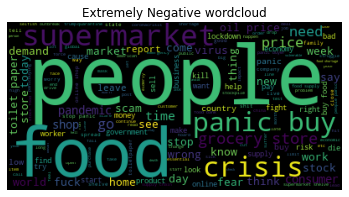

In [ ]:
create_wordcloud("Extremely Negative")

In [ ]:
def most_common_ngrams(sentiment, n_gram=1, n_common=10):
    wordlist = create_wordlist(sentiment)
    ngrams = zip(*[wordlist[i:] for i in range(n_gram)])
    counter = Counter(' '.join(ngram) for ngram in ngrams)
    return counter.most_common(n_common)

### Uni-grams

In [ ]:
most_common_ngrams("Positive")

[('store', 2739),
 ('grocery', 2329),
 ('price', 2247),
 ('supermarket', 2234),
 ('food', 2179),
 ('people', 1633),
 ('shop', 1593),
 ('consumer', 1570),
 ('online', 1241),
 ('need', 1177)]

In [ ]:
most_common_ngrams("Negative")

[('price', 2712),
 ('food', 2511),
 ('store', 2149),
 ('supermarket', 2080),
 ('grocery', 1795),
 ('people', 1661),
 ('shop', 1182),
 ('buy', 1167),
 ('consumer', 1142),
 ('panic', 1083)]

In [ ]:
most_common_ngrams("Neutral")

[('store', 1795),
 ('supermarket', 1541),
 ('grocery', 1412),
 ('price', 1269),
 ('consumer', 1151),
 ('shop', 953),
 ('food', 851),
 ('online', 770),
 ('people', 680),
 ('pandemic', 590)]

In [ ]:
most_common_ngrams("Extremely Positive")

[('store', 1676),
 ('grocery', 1288),
 ('help', 1259),
 ('supermarket', 1230),
 ('food', 1229),
 ('hand', 1212),
 ('shop', 1075),
 ('price', 1051),
 ('sanitizer', 1016),
 ('people', 949)]

In [ ]:
most_common_ngrams("Extremely Negative")

[('food', 1875),
 ('price', 1627),
 ('panic', 1460),
 ('people', 1437),
 ('supermarket', 1110),
 ('buy', 1096),
 ('store', 1006),
 ('crisis', 885),
 ('grocery', 809),
 ('shop', 639)]

### Bi-grams

In [ ]:
most_common_ngrams("Positive", n_gram=2)

[('grocery store', 1709),
 ('hand sanitizer', 722),
 ('online shop', 454),
 ('toilet paper', 403),
 ('stay home', 219),
 ('social distance', 215),
 ('oil price', 177),
 ('stock food', 175),
 ('panic buy', 169),
 ('store worker', 166)]

In [ ]:
most_common_ngrams("Negative", n_gram=2)

[('grocery store', 1381),
 ('panic buy', 572),
 ('oil price', 415),
 ('toilet paper', 411),
 ('online shop', 352),
 ('food bank', 194),
 ('stock food', 170),
 ('social distance', 163),
 ('stay home', 157),
 ('supermarket shelve', 155)]

In [ ]:
most_common_ngrams("Neutral", n_gram=2)

[('grocery store', 1077),
 ('toilet paper', 316),
 ('online shop', 304),
 ('social distance', 130),
 ('retail store', 116),
 ('consumer behavior', 115),
 ('oil price', 111),
 ('stock food', 105),
 ('stay home', 89),
 ('shop online', 80)]

In [ ]:
most_common_ngrams("Extremely Positive", n_gram=2)

[('grocery store', 1031),
 ('hand sanitizer', 773),
 ('online shop', 279),
 ('stay safe', 212),
 ('toilet paper', 197),
 ('stay home', 158),
 ('store worker', 148),
 ('shop online', 139),
 ('social distance', 130),
 ('wash hand', 127)]

In [ ]:
most_common_ngrams("Extremely Negative", n_gram=2)

[('panic buy', 694),
 ('grocery store', 620),
 ('oil price', 290),
 ('toilet paper', 240),
 ('buy food', 148),
 ('stop panic', 137),
 ('online shop', 122),
 ('supermarket shelve', 115),
 ('food supply', 114),
 ('supply chain', 110)]

## Models

In [ ]:
# Split train, test
#X = data.ProcessedTweet
X = data.OriginalTweet
y = data.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Vectorizers
count_vectorizer = CountVectorizer(tokenizer=preprocess)
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess, sublinear_tf=True, min_df=5)

X_train_vectorizer = count_vectorizer.fit_transform(X_train).toarray()

### Cross-Validation

In [ ]:
# models = [LogisticRegression(max_iter=100000),
#          MultinomialNB(alpha=0.1),
#          RandomForestClassifier(n_estimators=500, max_depth=50, random_state=0), 
#          DecisionTreeClassifier(random_state=0),
#          LinearSVC(max_iter=100000),
#          SGDClassifier(penalty='l1'),
#          XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=500, use_label_encoder=False)]

# models = [LogisticRegression(class_weight="balanced", random_state=0),
#          MultinomialNB(alpha=0.1),
#          RandomForestClassifier(class_weight="balanced", n_estimators=100, max_depth=10, random_state=0), 
#          DecisionTreeClassifier(class_weight="balanced", random_state=0),
#          LinearSVC(class_weight="balanced", random_state=0),
#          SGDClassifier(class_weight="balanced", penalty='l1', random_state=0),
#          XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=100, use_label_encoder=False, random_state=0)]

# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))

# entries = []
# for model in models:
#     model_name = model.__class__.__name__
#     accuracies = cross_val_score(model, X_train_vectorizer, y_train, scoring='accuracy', cv=CV)
#     for kFold, accuracy in enumerate(accuracies):
#         entries.append((model_name, kFold, accuracy))

# cv_df = pd.DataFrame(entries, columns=['model_name', 'kFold', 'accuracy'])

# mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
# std_accuracy = cv_df.groupby('model_name').accuracy.std()

# acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
# acc.columns = ['Mean Accuracy', 'Standard deviation']
# acc.sort_values(by=['Mean Accuracy'])

### Test models

In [ ]:
def test_model(vectorizer, predictor):
  model = Pipeline([
    ('vectorizer', vectorizer),
    ('predictor', predictor)
  ])

  model.fit(X_train, y_train)
  y_predicted = model.predict(X_test)

  print(classification_report(y_test, y_predicted))

In [ ]:
# Logistic Regression
logreg = LogisticRegression(max_iter=100000, class_weight="balanced", random_state=0)
test_model(tfidf_vectorizer, logreg)

                    precision    recall  f1-score   support

Extremely Negative       0.57      0.70      0.63      1570
Extremely Positive       0.58      0.71      0.64      1759
          Negative       0.55      0.43      0.48      2745
           Neutral       0.58      0.77      0.66      2105
          Positive       0.58      0.41      0.48      3060

          accuracy                           0.57     11239
         macro avg       0.57      0.61      0.58     11239
      weighted avg       0.57      0.57      0.56     11239



In [ ]:
#plot_confusion_matrix(model, y_test, y_predicted)

In [ ]:
# Multinomial Naive Bayes
multinb = MultinomialNB(alpha=0.1)
test_model(tfidf_vectorizer, multinb)

                    precision    recall  f1-score   support

Extremely Negative       0.62      0.27      0.38      1570
Extremely Positive       0.57      0.30      0.39      1759
          Negative       0.42      0.53      0.47      2745
           Neutral       0.62      0.40      0.49      2105
          Positive       0.40      0.62      0.49      3060

          accuracy                           0.46     11239
         macro avg       0.53      0.42      0.44     11239
      weighted avg       0.50      0.46      0.45     11239



In [ ]:
# Random Forest
random_forest = RandomForestClassifier(class_weight="balanced", n_estimators=100, max_depth=10, random_state=0)
test_model(tfidf_vectorizer, random_forest)

                    precision    recall  f1-score   support

Extremely Negative       0.46      0.68      0.55      1570
Extremely Positive       0.45      0.74      0.56      1759
          Negative       0.45      0.20      0.28      2745
           Neutral       0.40      0.82      0.54      2105
          Positive       0.52      0.09      0.15      3060

          accuracy                           0.44     11239
         macro avg       0.46      0.51      0.42     11239
      weighted avg       0.46      0.44      0.37     11239



In [ ]:
# Decision Tree
decision_tree = DecisionTreeClassifier(class_weight="balanced", random_state=0)
test_model(tfidf_vectorizer, decision_tree)

                    precision    recall  f1-score   support

Extremely Negative       0.46      0.48      0.47      1570
Extremely Positive       0.45      0.49      0.47      1759
          Negative       0.41      0.38      0.39      2745
           Neutral       0.53      0.59      0.56      2105
          Positive       0.44      0.40      0.42      3060

          accuracy                           0.46     11239
         macro avg       0.46      0.47      0.46     11239
      weighted avg       0.45      0.46      0.45     11239



In [ ]:
# Linear SVC
svc = LinearSVC(max_iter=100000, class_weight="balanced", random_state=0)
test_model(tfidf_vectorizer, svc)

                    precision    recall  f1-score   support

Extremely Negative       0.58      0.69      0.63      1570
Extremely Positive       0.57      0.71      0.63      1759
          Negative       0.52      0.42      0.47      2745
           Neutral       0.58      0.72      0.64      2105
          Positive       0.53      0.40      0.46      3060

          accuracy                           0.55     11239
         macro avg       0.56      0.59      0.57     11239
      weighted avg       0.55      0.55      0.55     11239



In [ ]:
sgd = SGDClassifier(class_weight="balanced", penalty='l1', random_state=0)
test_model(tfidf_vectorizer, sgd)

                    precision    recall  f1-score   support

Extremely Negative       0.45      0.86      0.59      1570
Extremely Positive       0.48      0.86      0.61      1759
          Negative       0.43      0.17      0.24      2745
           Neutral       0.52      0.84      0.64      2105
          Positive       0.58      0.12      0.20      3060

          accuracy                           0.49     11239
         macro avg       0.49      0.57      0.46     11239
      weighted avg       0.50      0.49      0.41     11239



In [46]:
xboost = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=100, use_label_encoder=False, random_state=0)
test_model(tfidf_vectorizer, xboost)

                    precision    recall  f1-score   support

Extremely Negative       0.63      0.46      0.53      1570
Extremely Positive       0.62      0.49      0.55      1759
          Negative       0.52      0.42      0.47      2745
           Neutral       0.56      0.69      0.62      2105
          Positive       0.46      0.58      0.51      3060

          accuracy                           0.53     11239
         macro avg       0.56      0.53      0.54     11239
      weighted avg       0.54      0.53      0.53     11239

